In [1]:
import pickle
from matplotlib import pyplot as plt
from human_hip.raw_data import get_brain_waves, cwt_spectrogram, spectrogram_plot, butter_filter
from human_hip.spike_data import read_autocurated_data, plot_raster
import numpy as np
from scipy.ndimage import gaussian_filter1d

from scipy.signal import hilbert, correlate
from astropy.stats import rayleightest, circmean, circstd

# Packages for plotting spectrogram
from scipy import ndimage
from matplotlib.colors import LogNorm #Normalize
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pickle 
from human_hip.histology import plot_histology, plot_histology_electrode_map
from human_hip.spike_data import read_phy_files, read_autocurated_data

import os
from sklearn.cluster import KMeans
import pandas as pd

# !pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
# set parameters
SB_TIMES = [
            [9, 28],
            [38, 52],
            [69, 83],
            [138, 151],
            [176, 187],
            [211, 220],
            [246, 254]
            ]



In [3]:
# general functions

def compute_rate_isi(sd, GAUSS_SIGMA=50, TIME_RANGE=[9,28]):
    
    if TIME_RANGE[0] < 0:
        TIME_RANGE[0] = 0
        print("WARNING: Start time set to 0s")

    # make empty result arrays
    rate_mat = np.zeros((len(sd.train), TIME_RANGE[1]*1000-TIME_RANGE[0]*1000))
    
    # for each unit
    for unit in range(len(sd.train)):
        
        # get spike times from sd
        spk_times= np.unique( np.round(sd.train[unit]).astype(int) )

        # remove spikes outside of time range under consideration
        spk_times = [x for x in spk_times if TIME_RANGE[0]*1000 <= x <= TIME_RANGE[1]*1000]

        # compute ISIs
        isi = np.diff(spk_times)
        
        # add spacer so that indices are the same
        isi = np.insert(isi, 0, 1)
        
        # compute firing rate based on isi
        isi_rate = 1/isi

        # make temporary result array
        isi_rate_temp_result = np.zeros((TIME_RANGE[1]*1000-TIME_RANGE[0]*1000, 1))
        
        # for each spike except the first
        for spk in range(1, len(spk_times)):
            
            # store rates at corresponding spike times
            isi_rate_temp_result[spk_times[spk-1]-TIME_RANGE[0]*1000:spk_times[spk]-TIME_RANGE[0]*1000] = isi_rate[spk]

        # compute firing rates and store
        rate_mat[unit,:] = 1000*gaussian_filter1d(isi_rate_temp_result, GAUSS_SIGMA).squeeze()
    
    return rate_mat

# # #

def compute_cross_corr_lag_range(input_data, MAX_LAG, norm=True):

    # Initialize the output matrices
    max_corr = np.zeros((input_data.shape[0], input_data.shape[0]))
    lag_times = np.zeros((input_data.shape[0], input_data.shape[0]))

    # Compute the cross-correlations
    for i in range(input_data.shape[0]):
        print(i)

        signal1_scaled = input_data[i, :] - np.mean(input_data[i, :])
        if norm:
            signal1_scaled = signal1_scaled / np.linalg.norm(signal1_scaled)

        for j in range(input_data.shape[0]):
            if i != j:

                signal2_scaled = input_data[j, :] - np.mean(input_data[j, :])
                if norm:
                    signal2_scaled = signal2_scaled / np.linalg.norm(signal2_scaled)

                r = correlate(signal1_scaled, signal2_scaled, mode='full')
                r = r[r.size // 2 - MAX_LAG: r.size // 2 + MAX_LAG + 1] 
                r_norm = r / (np.std(signal1_scaled) * np.std(signal2_scaled) * len(signal1_scaled))
                if np.max(r_norm)>1:
                    print(len(input_data[i, :]))
                    print(len(input_data[j, :]))
                    print(np.std(input_data[i, :]) * np.std(input_data[j, :]) * len(input_data[i, :]))
                    print("ERROR")
                max_corr[i, j] = np.max(r_norm) #r[np.argmax(np.abs(r))] #  
                lag_times[i, j] = np.argmax(np.abs(r_norm)) - MAX_LAG
            else:
                max_corr[i, j] = 1  # Autocorrelation is 1 at lag 0
                lag_times[i, j] = 0

    return max_corr, lag_times

# # #

# Function to find the k closest rows
def find_k_closest_rows(arr1, arr2, k):
    distances = np.linalg.norm(arr1[:, np.newaxis] - arr2, axis=2)
    closest_indices = np.argsort(distances, axis=1)[:, :k]
    return closest_indices

# # #

# population rate for selection of units
def compute_clus_pop_rate(sd, selec_units):

    # make spikedata object of subset of units
    subset_sd = sd[selec_units]

    # compute population rate for subset
    pop_fr = gaussian_filter1d(subset_sd.binned(bin_size=1).astype(float), sigma=20)

    return pop_fr

# # #

def plot_clus_pop_rate(pop_fr0, pop_fr1, x_lim):

    # Create the figure and axis
    fig, ax = plt.subplots()

    # get x-values
    x_vals = np.linspace(0, len(pop_fr0)/1000, len(pop_fr0)+1)[1:]

    # Plot the lines
    ax.plot(x_vals, pop_fr0, color='blue', label='Clus0')
    ax.plot(x_vals, pop_fr1, color='red', label='Clus1')

    # Add a legend
    ax.legend()

    # specify xlim
    plt.xlim(x_lim)

    # Show the plot
    plt.show()

# # #

def plot_clus_pop_rate_theta(pop_fr0, pop_fr1, x_lim):

    # obtain population firing rate for x_lim only
    pop_fr0_cut = pop_fr0[x_lim[0]*1000:x_lim[1]*1000]
    pop_fr1_cut = pop_fr1[x_lim[0]*1000:x_lim[1]*1000]

    # filter firing rate for theta frequency
    pop_fr0_cut_theta = butter_filter(pop_fr0_cut, 4, 8, fs=1000)
    pop_fr1_cut_theta = butter_filter(pop_fr1_cut, 4, 8, fs=1000)

    # Create the figure and axis
    fig, ax = plt.subplots()

    # get x-values
    x_vals = np.linspace(x_lim[0],x_lim[1],len(pop_fr0_cut_theta)+1)[1:]

    # Plot the lines
    ax.plot(x_vals, pop_fr0_cut_theta, color='blue', label='Clus0')
    ax.plot(x_vals, pop_fr1_cut_theta, color='red', label='Clus1')

    # Add a legend
    ax.legend()

    # specify xlim
    plt.xlim(x_lim)

    # Show the plot
    plt.show()

In [4]:
# load spike data whole recording
sd = read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


[9, 28]
[38, 52]
[138, 151]
[176, 187]
[211, 220]
[246, 254]


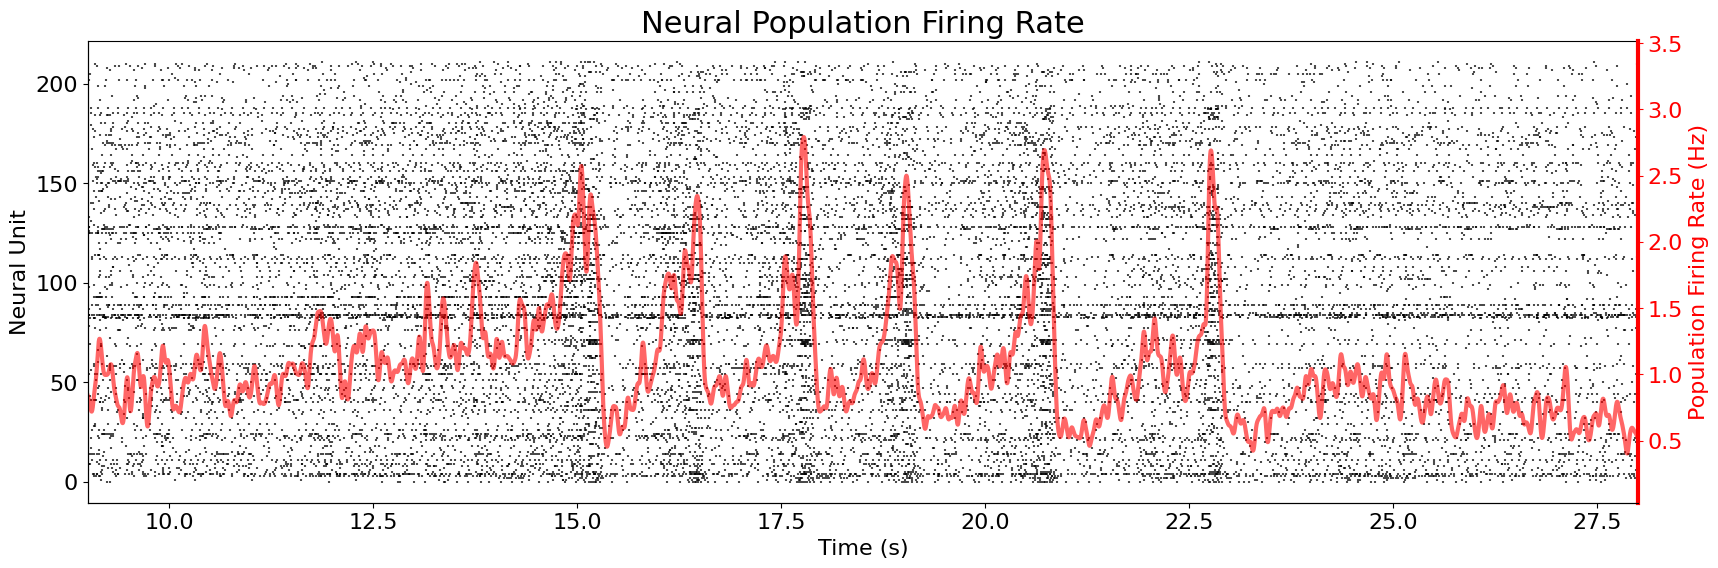

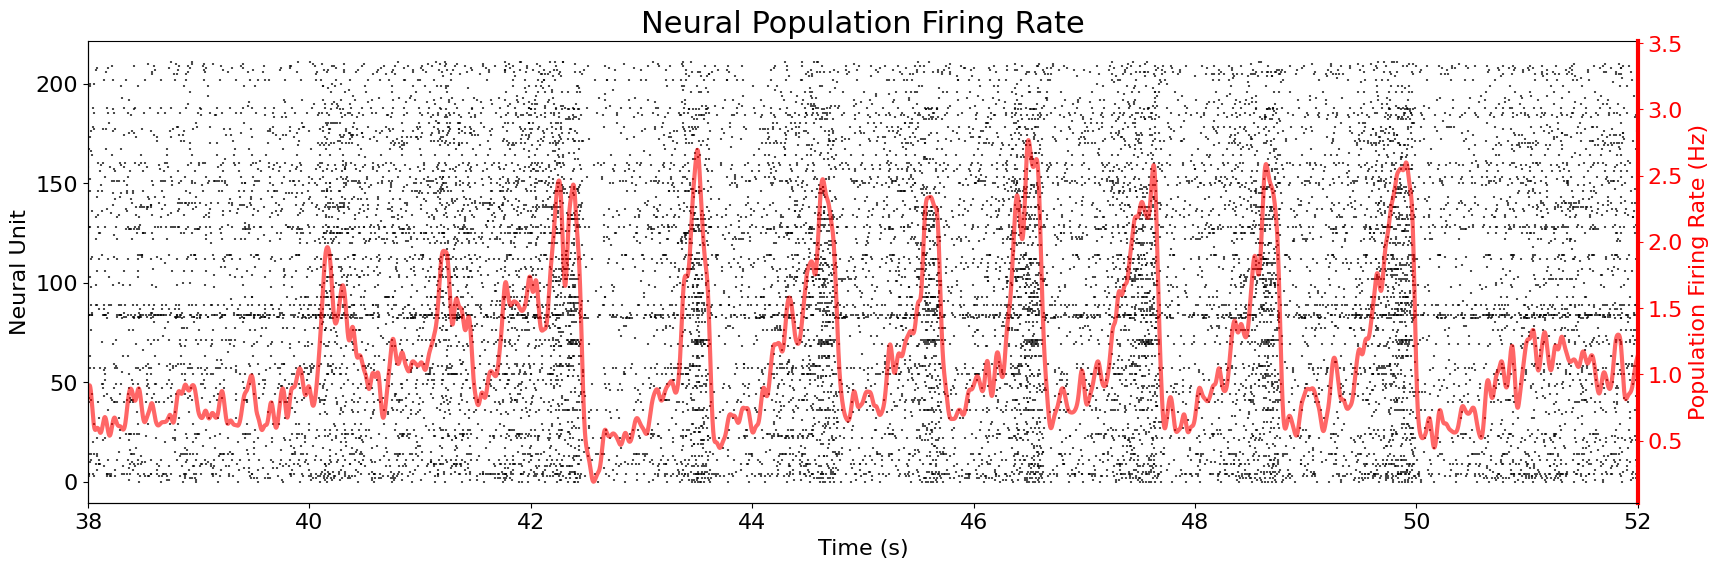

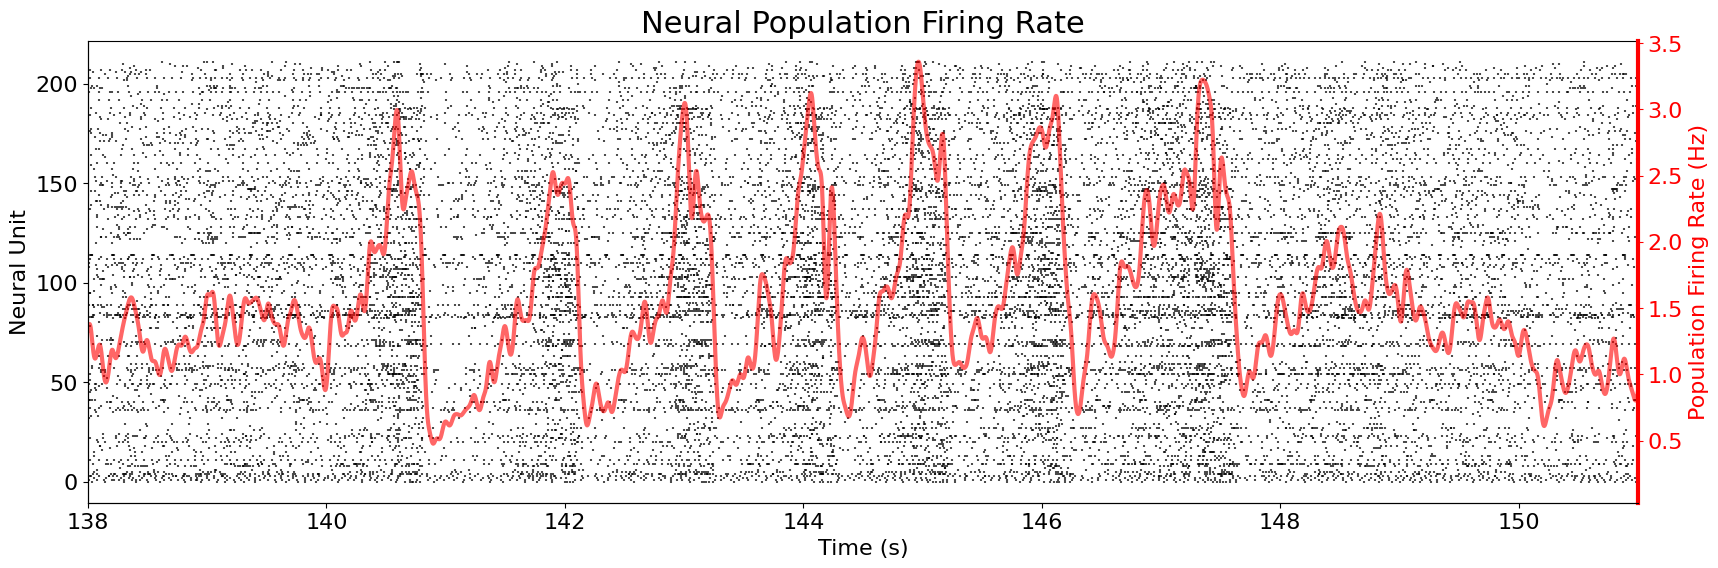

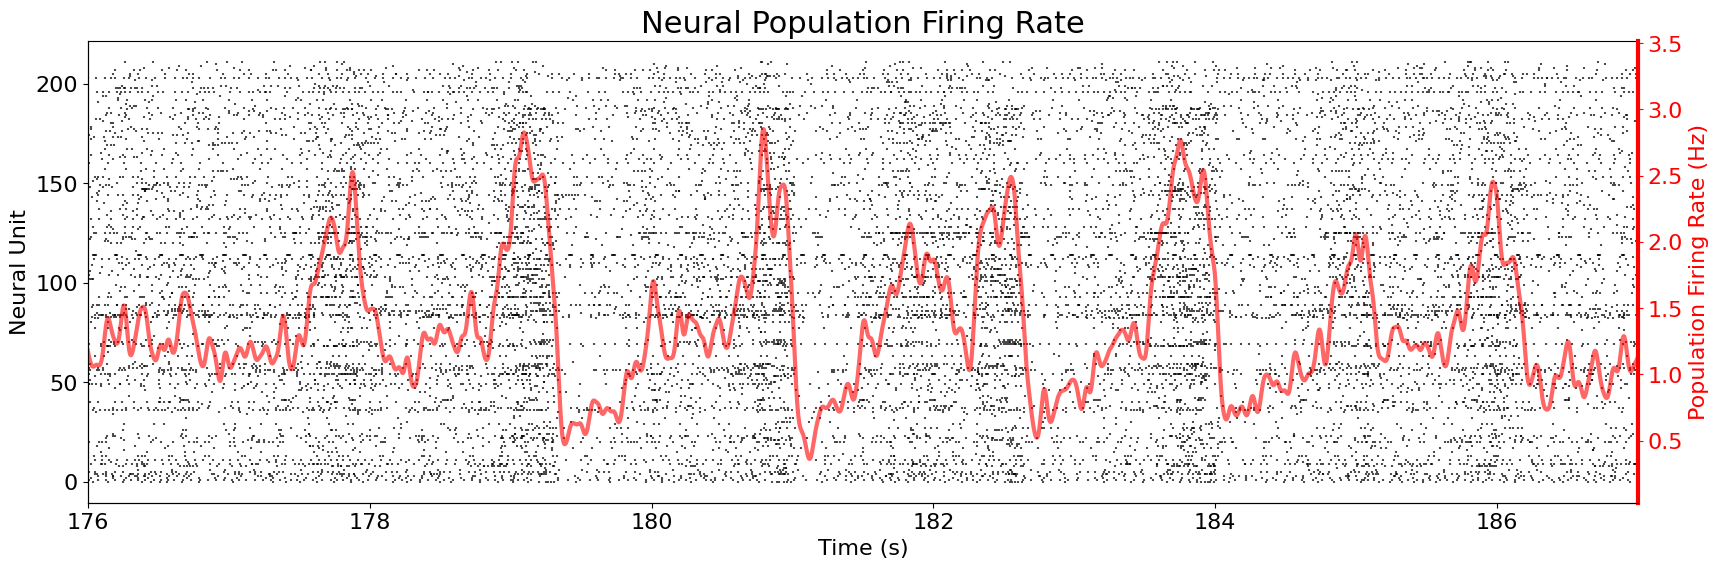

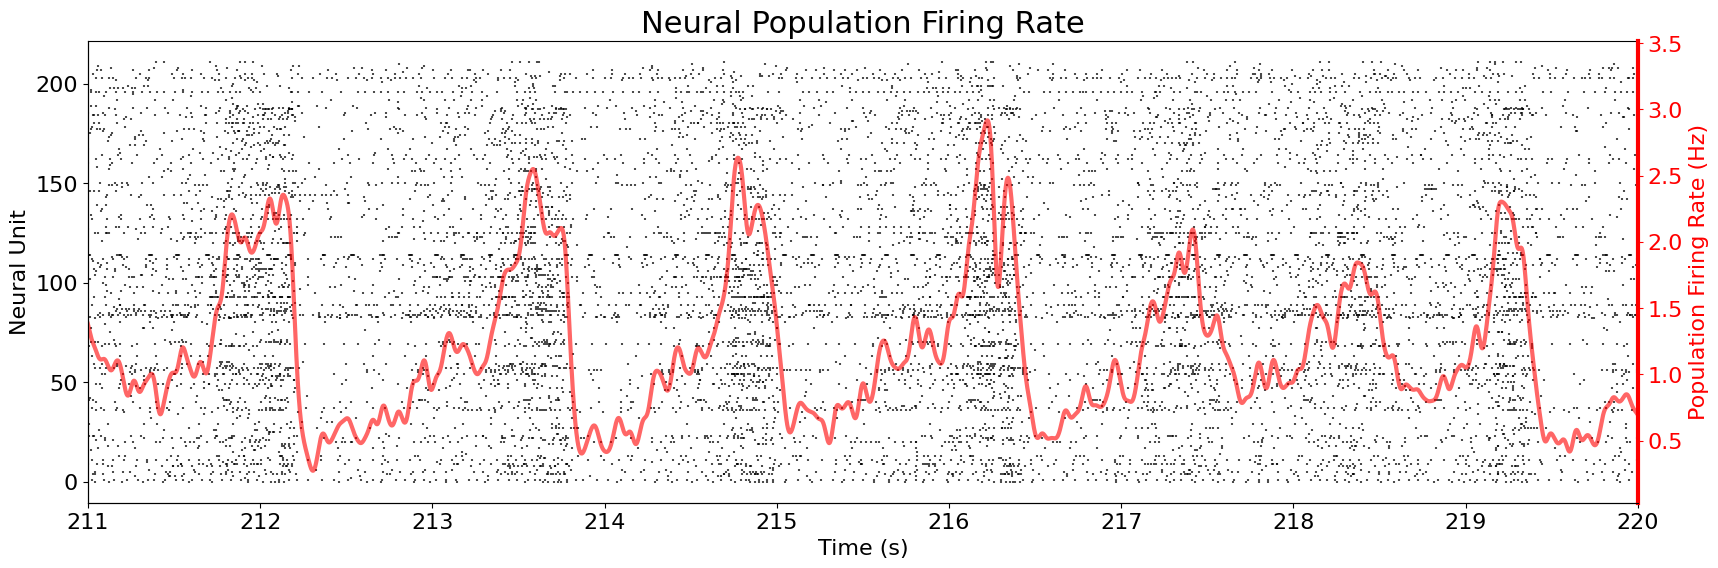

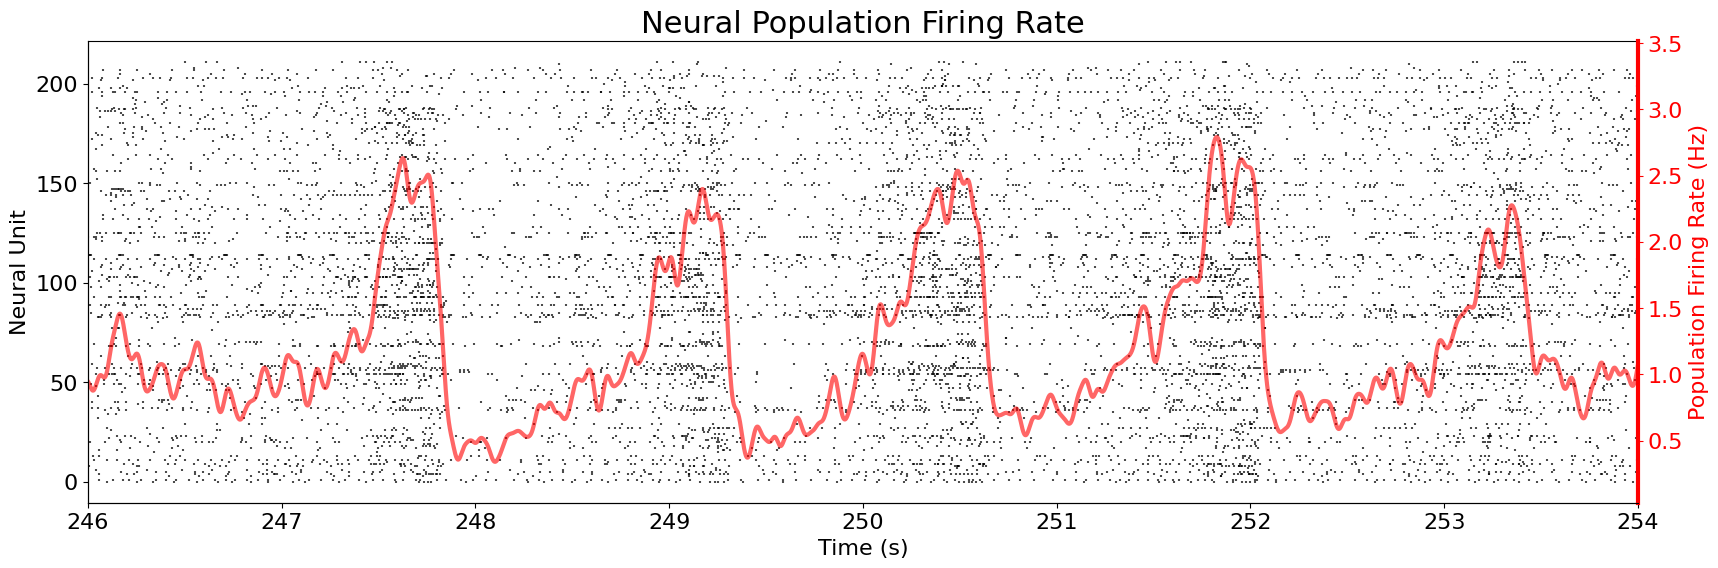

In [8]:
# plot rasterplots for all superbursts

for sb in SB_TIMES:
    plot_raster(sd, xlim=(sb[0], sb[1]), title="Neural Population Firing Rate",size=(20,6))


In [22]:
# specify superburst of interest
SB_OI = 0

# load LFP data
with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/acid1_start{}s_stop{}s_fs1ms.pkl".format(SB_TIMES[SB_OI][0], SB_TIMES[SB_OI][1]), 'rb') as filename:
    data_raw = pickle.load(filename)

print(data_raw.keys())
print(data_raw["data"].shape)

dict_keys(['data', 'xy', 'frame_rate'])
(1009, 19000)


In [23]:
# filter LFP data into individual frequency bands
data = get_brain_waves(data_raw["data"], data_raw["frame_rate"]) #[wave_type]  # get common brain waves

print(data.keys())
print(data["theta"].shape)

dict_keys(['original', 'basic', 'low', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
(1009, 19000)


[9, 28]
computing correlations


(1009, 19000)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


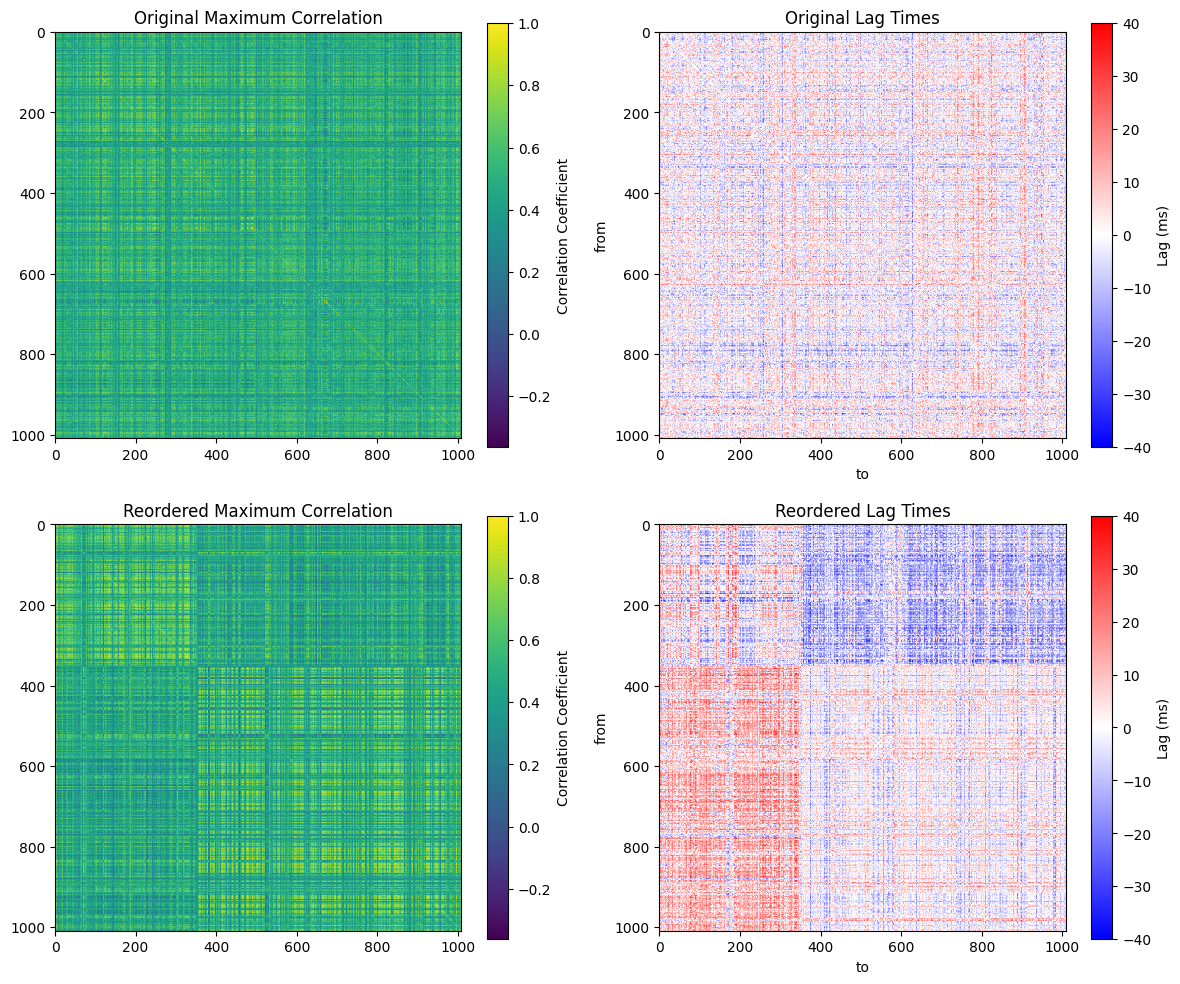

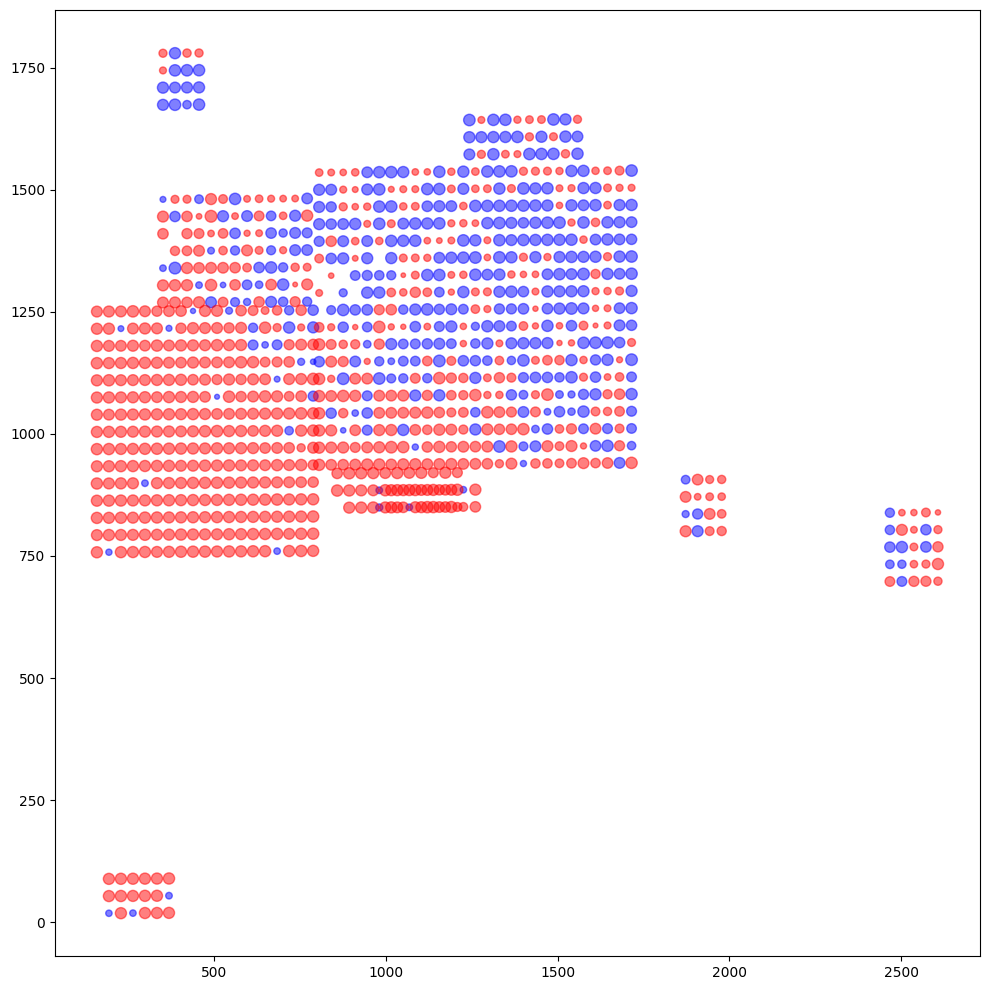

In [10]:
# Set the maximum lag time in ms (1 theta cycle is 125-250ms)
MAX_LAG = 100
NCLUS = 2
SEED = 1

for sb in [SB_TIMES[0]]:
    print(sb)

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_recomp_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # load LFP data
    with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
        data_raw = pickle.load(filename)

    # obtain electrode coordinates
    elec_xy = data_raw["xy"].copy()
    elec_xy[:,1] = data_raw["xy"][:,0]/12.5
    elec_xy[:,0] = data_raw["xy"][:,1]

    # if results already exist
    if os.path.exists(data_save_path) and False:
        
        print("loading saved results")

        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            max_corr = data['max_corr']
            lag_times = data['lag_times']

    else:
        
        print("computing correlations")

        # filter LFP data into individual frequency bands
        data = get_brain_waves(data_raw["data"], data_raw["frame_rate"]) #[wave_type]  # get common brain waves

        # get theta filtered data
        theta_filt = data["theta"]
        print(theta_filt.shape)

        max_corr, lag_times = compute_cross_corr_lag_range(theta_filt[:,5400:6000], MAX_LAG, norm=False) # 5400:6000

        # # Save the data to a file
        # with open(data_save_path, 'wb') as f:
        #     pickle.dump({'theta_filt': theta_filt, 'max_corr': max_corr, 'lag_times': lag_times}, f)

        # print("results saved")



    # Perform k-means clustering on the lag_times matrix
    kmeans = KMeans(n_clusters=NCLUS, random_state=SEED).fit(lag_times)
    labels = kmeans.labels_

    # Reorder the matrices based on the cluster labels
    reordered_max_corr = max_corr[:, np.argsort(labels)][np.argsort(labels), :]
    reordered_lag_times = lag_times[:, np.argsort(labels)][np.argsort(labels), :]

    # Compute the average correlation score within each cluster
    avg_corr_scores = np.zeros_like(labels, dtype=float)
    for i in np.unique(labels):
        cluster_corr = max_corr[labels == i, :]
        cluster_corr = cluster_corr[:, labels == i]
        avg_corr_scores[labels == i] = np.mean(cluster_corr, axis=0)




    # Create a figure with a 2x2 subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Plot the original max_corr heatmap
    im1 = ax1.imshow(max_corr, cmap='viridis')
    ax1.set_title('Original Maximum Correlation')

    # Plot the original lag_times heatmap with the bwr colormap
    im2 = ax2.imshow(lag_times, cmap='bwr')
    ax2.set_title('Original Lag Times')
    ax2.set_xlabel('to')
    ax2.set_ylabel('from')

    # Plot the reordered max_corr heatmap
    im3 = ax3.imshow(reordered_max_corr, cmap='viridis')
    ax3.set_title('Reordered Maximum Correlation')

    # Plot the reordered lag_times heatmap with the bwr colormap
    im4 = ax4.imshow(reordered_lag_times, cmap='bwr')
    ax4.set_title('Reordered Lag Times')
    ax4.set_xlabel('to')
    ax4.set_ylabel('from')

    # Show the colorbars
    fig.colorbar(im1, ax=ax1, label='Correlation Coefficient')
    fig.colorbar(im2, ax=ax2, label='Lag (ms)')
    fig.colorbar(im3, ax=ax3, label='Correlation Coefficient')
    fig.colorbar(im4, ax=ax4, label='Lag (ms)')

    plt.tight_layout()
    plt.show()
    # plt.savefig(fig_save_path + "2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.png".format(sb[0], sb[1], MAX_LAG))
    # print("correlation matrix figure saved")



    # Create the scatterplot
    plt.figure(figsize=(10, 10))

    for label in np.unique(labels):
        cluster_av_corr = avg_corr_scores[labels==label]
        cluster_av_corr[cluster_av_corr<0]=0
        cluster_xy = elec_xy[labels == label,:]
        plt.scatter(cluster_xy[:, 0], cluster_xy[:, 1], s=cluster_av_corr * 100, c=['blue' if label == 0 else 'red'],
                    alpha=0.5)

    # Set the aspect ratio to 'equal'
    # plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()
    # plt.savefig(fig_save_path + "2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_clus_loc_start{}s_stop{}s_maxlag{}.png".format(sb[0], sb[1], MAX_LAG))
    # print("cluster location figure saved")

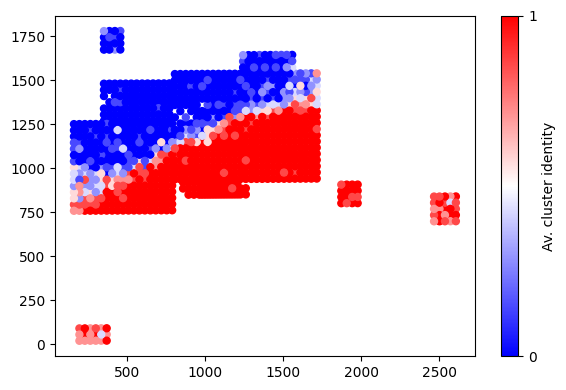

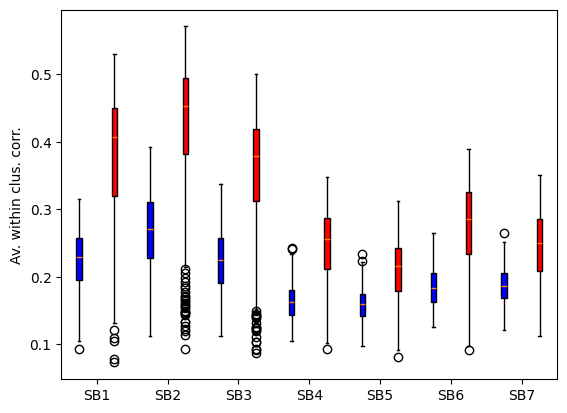

                  sum_sq      df            F         PR(>F)
C(CLUS)        19.012692     1.0  5503.011521   0.000000e+00
C(SB)          22.653149     6.0  1092.783575   0.000000e+00
C(CLUS):C(SB)   3.056179     6.0   147.429480  8.646292e-177
Residual       24.354022  7049.0          NaN            NaN


In [16]:
# Compare different superbursts
MAX_LAG = 50
NCLUS = 2
SEED = 1

# # # plot functions # # #
def create_boxplot(data, ylab):
    
    sb_list = []
    clus_list = []
    av_corr_list = []

    # initiate figure
    fig, ax = plt.subplots()
    
    # for each dictionary item
    for i, (key, value) in enumerate(data.items()):
        
        # plot boxplot
        bp = ax.boxplot(value, positions=[i*2, i*2+1], patch_artist=True)
        
        # for each plotted box
        for box in bp['boxes']:

            # set facecolor
            box.set_facecolor(['blue', 'red'][bp['boxes'].index(box)])

        # for each cluster
        for j, clus in enumerate(value):

            # store data for anova analysis
            sb_list.extend([key] * len(clus))
            clus_list.extend(['Blue' if j == 0 else 'Red'] * len(clus))
            av_corr_list.extend(clus)

    # adjust tick labels
    ax.set_xticks(np.arange(len(data)) * 2 + 0.5)
    ax.set_xticklabels(["SB{}".format(key+1) for key in data.keys()])

    # set ylabel
    ax.set_ylabel(ylab)

    plt.show()

    # organize data for anova analysis in dataframe
    df = pd.DataFrame({
        'SB': sb_list,
        'CLUS': clus_list,
        'AV_CORR': av_corr_list
    })

    # Perform two-way ANOVA
    model = ols('AV_CORR ~ C(CLUS) + C(SB) + C(CLUS):C(SB)', data=df).fit()
    anova_table = anova_lm(model, typ=2)

    # print anova results
    print(anova_table)

# # #

def plot_av_clus_scatter(elec_xy, data_dict):

    # Initiate figure
    plt.figure(figsize=(6, 4))

    # Calculate the averaged values for the colormap
    avg_values = np.array([np.mean([val[i] for val in data_dict.values()]) for i in range(len(next(iter(data_dict.values()))))])

    # Create the scatterplot
    plt.scatter(elec_xy[:, 0], elec_xy[:, 1], s=25, c=avg_values, cmap='bwr', vmin=0, vmax=1)

    # Create the colorbar
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])
    cbar.set_label('Av. cluster identity')

    # Show the plot
    plt.tight_layout()
    plt.show()

    return avg_values


# initiate empty result dictionaries
all_clus_labels = {}
av_clus_corr = {}

# for every superburst
for i, sb in enumerate(SB_TIMES):

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # if results already exist
    if os.path.exists(data_save_path):
        
        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            max_corr = data['max_corr']
            lag_times = data['lag_times']

    else:

        print("WARNING: no saved data for superburst: {}s to {}s".format(sb[0], sb[1]))

    # Perform k-means clustering on the lag_times matrix
    kmeans = KMeans(n_clusters=NCLUS, random_state=SEED).fit(lag_times)
    labels = kmeans.labels_

    # Compute the average correlation score within each cluster
    av_clus_corr[i] = [None] * len(np.unique(labels))

    # for each cluster
    for j in np.unique(labels):
        
        # select only within cluster correlations
        cluster_corr = max_corr[labels == j, :]
        cluster_corr = cluster_corr[:, labels == j]

        # compute average within cluster correlation
        av_clus_corr[i][j] = np.mean(cluster_corr, axis=0)

    # save results in dictionaries
    all_clus_labels[i] = labels


# load LFP data
with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/acid1_start{}s_stop{}s_fs1ms.pkl".format(SB_TIMES[0][0], SB_TIMES[0][1]), 'rb') as filename:
    data_raw = pickle.load(filename)

# obtain electrode coordinates
elec_xy = data_raw["xy"].copy()
elec_xy[:,1] = data_raw["xy"][:,0]/12.5
elec_xy[:,0] = data_raw["xy"][:,1]

# plot cluster locations
av_clus_vals = plot_av_clus_scatter(elec_xy, all_clus_labels)


# plot average correlation results
create_boxplot(av_clus_corr, "Av. within clus. corr.")

/tmp/ipykernel_1834/3251395800.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for unit in sd.neuron_data[0].values():


[9, 28]


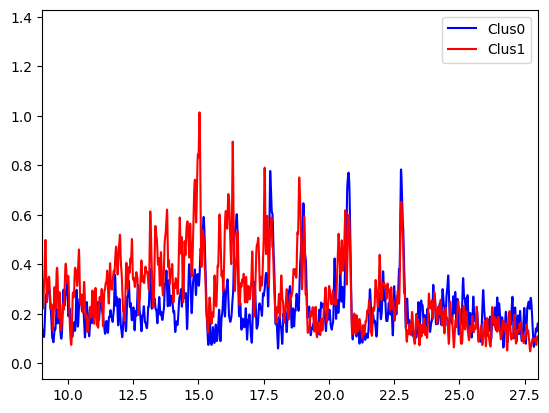

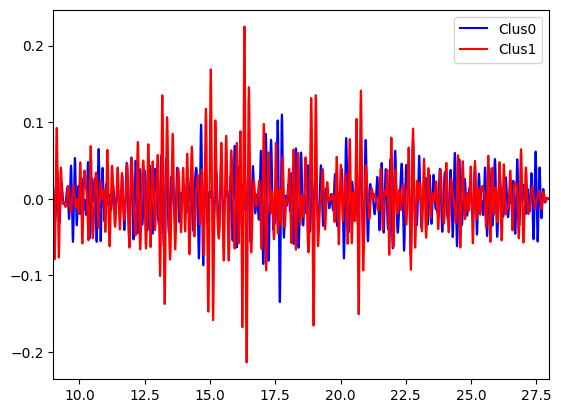

[38, 52]


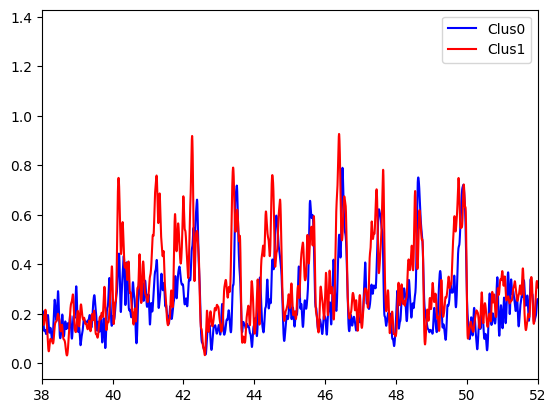

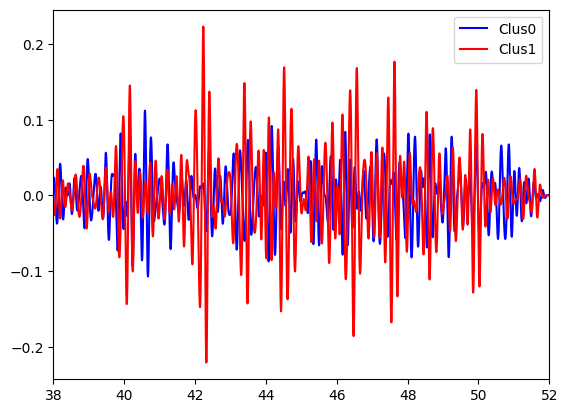

[69, 83]


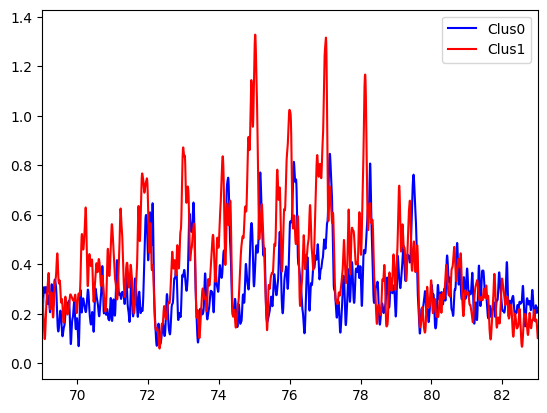

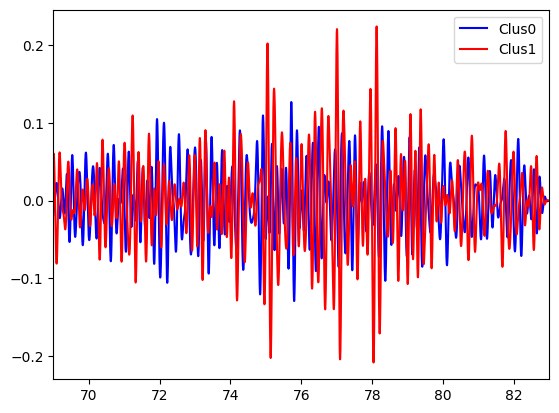

[138, 151]


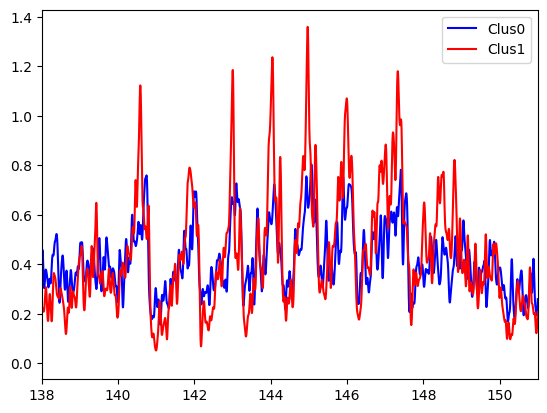

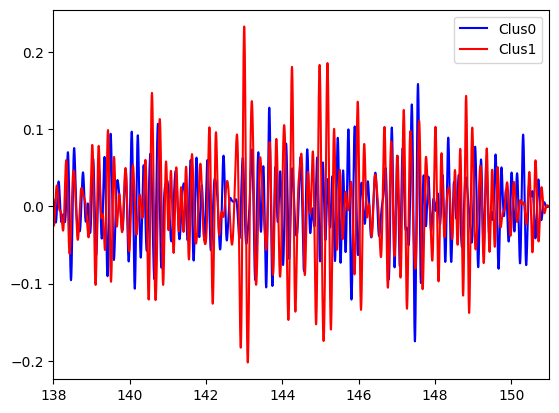

[176, 187]


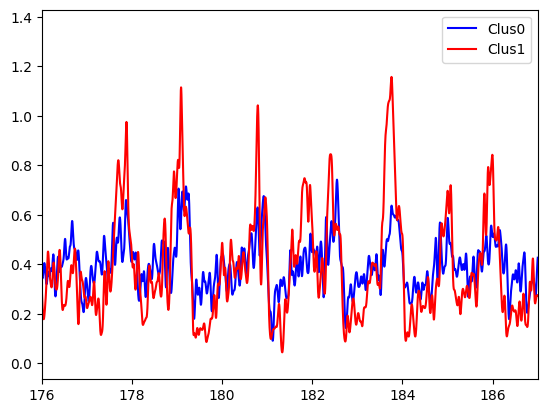

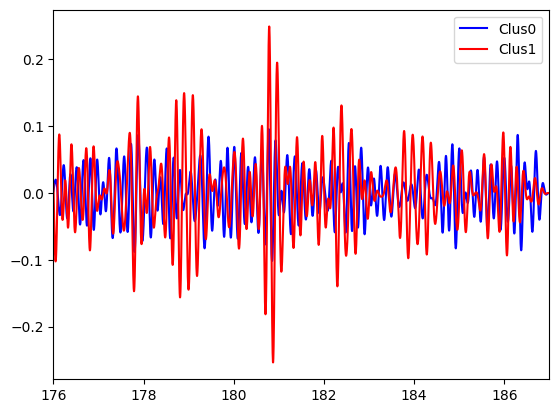

[211, 220]


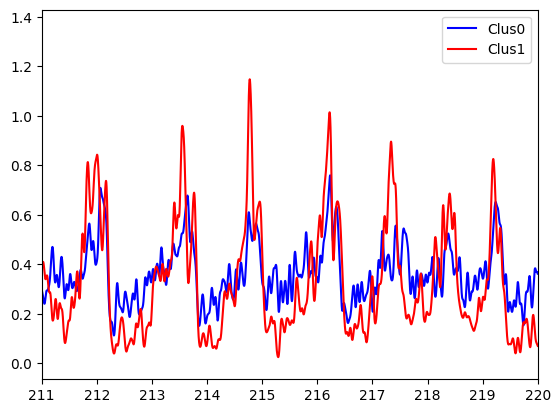

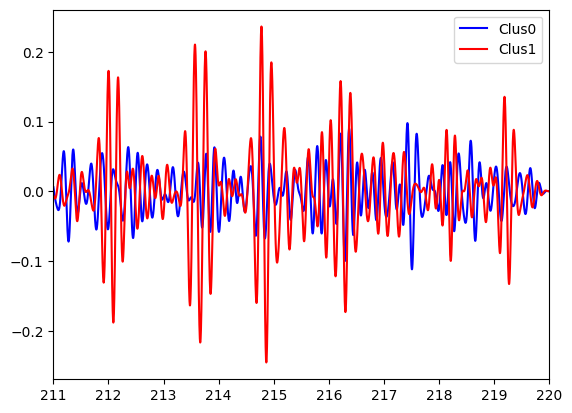

[246, 254]


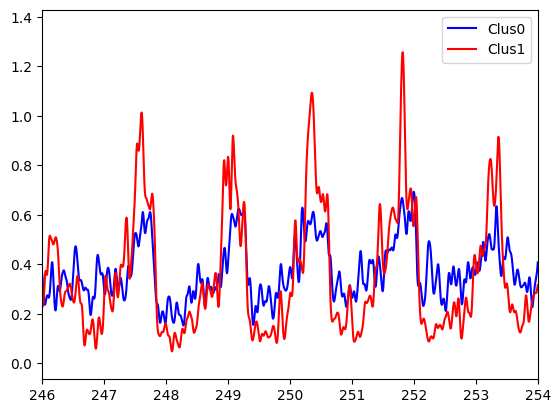

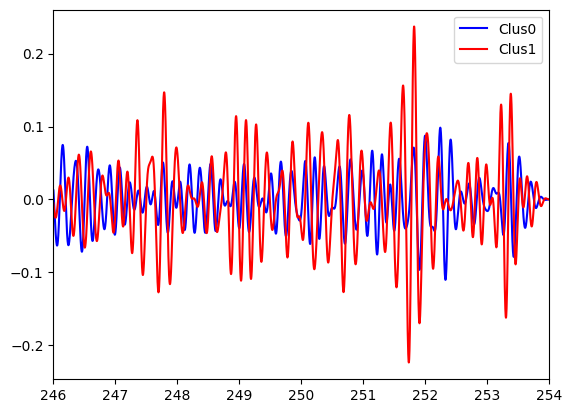

In [17]:
NUM_CLOSEST = 4 # number of closest electrodes to unit
MAX_CLUS_SCORE = 0.1 # maximum cluster identity score summed over NUM_CLOSEST electrodes to assign unit to cluster

# get locations for units
unit_xy = []
for unit in sd.neuron_data[0].values():
    unit_xy.append([unit['position'][0], unit['position'][1]] )
unit_xy = np.array(unit_xy)


# find NUM_CLOSEST closest electrodes to each unit
closest_elecs = find_k_closest_rows(unit_xy, elec_xy, NUM_CLOSEST)

# make empty result lists
clus0_units = set()
clus1_units = set()
unit_av_clus_id = np.zeros((unit_xy.shape[0],))

# for each unit
for unit in range(unit_xy.shape[0]):
    
    # get cluster identity of NUM_CLOSEST closest electrodes
    close_clusters = [av_clus_vals[i] for i in closest_elecs[unit,:]]
    
    unit_av_clus_id[unit] = np.mean(close_clusters)

    # if unit location corresponds to electrode that is fully cluster 0
    if unit_av_clus_id[unit] < MAX_CLUS_SCORE:
        clus0_units.add(unit)
    elif 1-unit_av_clus_id[unit] < MAX_CLUS_SCORE:
        clus1_units.add(unit)
        

# Obtain population rate per cluster
pop_fr0 = compute_clus_pop_rate(sd, clus0_units)
pop_fr1 = compute_clus_pop_rate(sd, clus1_units)

SB_TIMES = [
            [9, 28],
            [38, 52],
            [69, 83],
            [138, 151],
            [176, 187],
            [211, 220],
            [246, 254]
            ]

# SB_TIMES = [
#             [12, 20],
#             [43, 48],
#             [69, 83],
#             [138, 151],
#             [176, 187],
#             [211, 220],
#             [246, 254]
#             ]

for sb in SB_TIMES:

    print(sb)
    
    # plot population rates
    plot_clus_pop_rate(pop_fr0, pop_fr1, sb)
    plot_clus_pop_rate_theta(pop_fr0, pop_fr1, sb)

    # # compute cross correlation and lag
    # cross_cor, max_lag = compute_cross_corr_lag_range(np.vstack((pop_fr0[sb[0]*1000:sb[1]*1000], pop_fr1[sb[0]*1000:sb[1]*1000])), 125)
    
    # print(max_lag[0,1])



In [41]:
# # # SPIKE PHASE LOCKING # # #

SIG_THRESH = 0.05
NUM_CLOSEST = 4
PLOT_SIG = False

def plot_polar_hist(radian_values, nbins=16, bar_color="b"):
    
    # Initiate a figure with polar axis
    ax = plt.subplot(111, polar=True)

    # bin the radian values
    counts, bin_edges = np.histogram(radian_values, bins=nbins, range=(-np.pi, np.pi))
    bin_centers = bin_edges[:-1] + 0.5*np.diff(bin_edges)

    # plot bin results as a barplot on polar axis
    ax.bar(bin_centers, counts, color=bar_color, width=np.diff(bin_edges), bottom=0.0)

    plt.show()
    return

def plot_phase_lock_sig(spk_times, av_nearby_theta, all_nearby_theta, x_lim=None):

    # Initiate figure
    plt.figure(figsize=(10, 4))

    # plot average signal
    plt.plot(range(len(av_nearby_theta)), av_nearby_theta, "k", linewidth=2)

    # if av_nearby_theta is averaged over more than one electrode
    if all_nearby_theta.shape[0] > 1:

        # for each averaged electrode
        for i in range(all_nearby_theta.shape[0]):

            # plot signal
            plt.plot(range(len(av_nearby_theta)), all_nearby_theta[i,:]/2+(i+1)*10, "b", linewidth=1)

    # for each spike
    for spk in spk_times:

        plt.scatter(spk, av_nearby_theta[spk], s=50, c="r")
    
    if x_lim == None:
        plt.xlim([0,len(av_nearby_theta)])
    else:
        plt.xlim(x_lim)

    plt.xticks([])
    plt.yticks([])

    plt.show()
    return



# initiate empty result array
rayleigh_p = np.empty((len(SB_TIMES),len(sd.train)))
rayleigh_p[:] = np.nan
mean_angle = np.empty((len(SB_TIMES),len(sd.train)))
mean_angle[:] = np.nan

# for each superburst
for i, sb in enumerate(SB_TIMES):
    print(sb)

    # load LFP data
    with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
        data_raw = pickle.load(filename)

    # filter LFP data into individual frequency bands
    data = get_brain_waves(data_raw["data"], data_raw["frame_rate"]) #[wave_type]  # get common brain waves

    # get theta filtered data
    theta_filt = data["theta"]

    # if this is the first iteration of the loop
    if i == 0:

        # obtain electrode coordinates
        elec_xy = data_raw["xy"].copy()
        elec_xy[:,1] = data_raw["xy"][:,0]/12.5
        elec_xy[:,0] = data_raw["xy"][:,1]

        # obtain unit locations
        unit_xy = []
        for unit in sd.neuron_data[0].values():
            unit_xy.append([unit['position'][0], unit['position'][1]] )
        unit_xy = np.array(unit_xy)

        # find NUM_CLOSEST closest electrodes to each unit
        closest_elecs = find_k_closest_rows(unit_xy, elec_xy, NUM_CLOSEST)


    # for each unit
    for unit in range(len(sd.train)):

        # average the theta LFP over the closest electrodes
        av_nearby_theta = np.mean(theta_filt[closest_elecs[unit,:], :], axis=0)

        # compute the phase angles of the averaged theta
        nearby_angles = np.angle(hilbert(av_nearby_theta))

        # get spike times from sd
        spk_times= np.unique( np.round(sd.train[unit]).astype(int) )

        # filter for spike times in superburst only
        sb_spk_times = spk_times[(spk_times > sb[0]*1000) & (spk_times < sb[1]*1000)]

        # obtain all spike time angles
        spk_angles = nearby_angles[sb_spk_times-sb[0]*1000]

        # compute p-value of rayleigh test and store
        rayleigh_p[i, unit] = rayleightest(spk_angles)
        mean_angle[i, unit] = circmean(spk_angles)

        # if result is significant
        if rayleigh_p[i, unit] < SIG_THRESH and PLOT_SIG:

            print(sb)
            print(unit)
            print(unit_xy[unit,:])
            print(rayleigh_p[i, unit])
            print(unit_av_clus_id[unit])

            plot_polar_hist(spk_angles)
            plot_phase_lock_sig(sb_spk_times-sb[0]*1000, av_nearby_theta, theta_filt[closest_elecs[unit,:], :], [5000,15000])

            print("\n\n")

# define data save path given parameters
data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_spike_locking.pkl"

# Save the data to a file
with open(data_save_path, 'wb') as f:
    pickle.dump({'rayleigh_p': rayleigh_p, 'mean_angle': mean_angle, "unit_av_clus_id":unit_av_clus_id}, f)

print("Results saved")

[9, 28]


/tmp/ipykernel_1834/3443251863.py:87: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for unit in sd.neuron_data[0].values():


[38, 52]
[69, 83]
[138, 151]
[176, 187]


/srv/conda/envs/notebook/lib/python3.10/site-packages/astropy/stats/circstats.py:40: RuntimeWarning: invalid value encountered in scalar divide
  C = np.sum(weights * np.cos(p * (data - phi)), axis) / np.sum(weights, axis)
/srv/conda/envs/notebook/lib/python3.10/site-packages/astropy/stats/circstats.py:41: RuntimeWarning: invalid value encountered in scalar divide
  S = np.sum(weights * np.sin(p * (data - phi)), axis) / np.sum(weights, axis)


[211, 220]
[246, 254]
Results saved


In [10]:
print(unit_av_clus_id.shape)
print(mean_angle.shape)
print(rayleigh_p.shape)

(212,)
(7, 212)
(7, 212)


In [24]:

print(circmean(mean_angle, axis=0).shape)
print(circstd(mean_angle, axis=0).shape)


(212,)
(212,)


Text(0, 0.5, '# Superbursts')

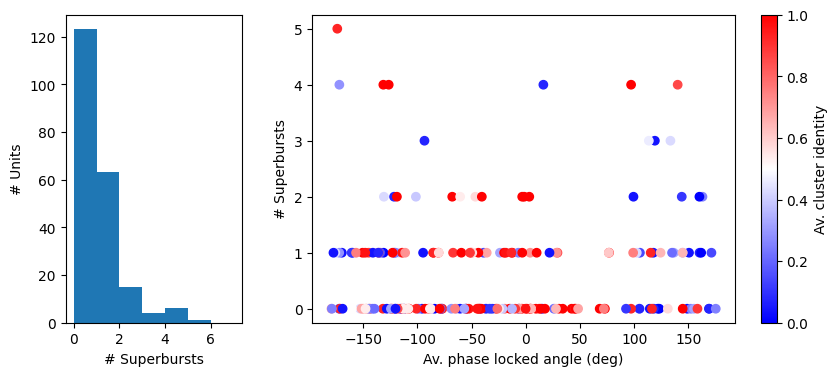

In [34]:
import math

SIG_THRESH = 0.05


# Count for each column how many rows are below 0.05
locked_sb = np.sum(rayleigh_p <= SIG_THRESH, axis=0)

# compute circular mean and std of locked angle over all superbursts
av_phase = circmean(mean_angle, axis=0)
std_phase = circstd(mean_angle, axis=0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 3]})

# Plot a histogram of the counts in the first subplot
ax1.hist(locked_sb, bins=range(rayleigh_p.shape[0]+1))#, align='left', rwidth=0.8)
ax1.set_xlabel('# Superbursts')
ax1.set_ylabel('# Units')

# Plot a scatterplot in the second subplot
scatter = ax2.scatter([math.degrees(p) for p in av_phase], locked_sb, c=unit_av_clus_id, cmap="bwr")#, s=1./(std_phase**2))
cb = fig.colorbar(scatter, ax=ax2)
cb.set_label('Av. cluster identity')
ax2.set_xlabel('Av. phase locked angle (deg)')
ax2.set_ylabel('# Superbursts')



[9, 28]


/tmp/ipykernel_1834/1085123317.py:30: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for unit in sd.neuron_data[0].values():


[38, 52]
[69, 83]
[138, 151]
[176, 187]
[211, 220]
[246, 254]


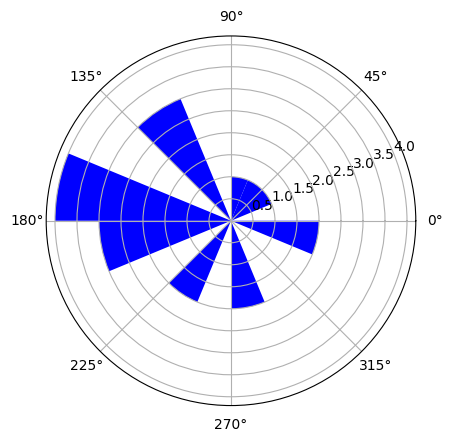

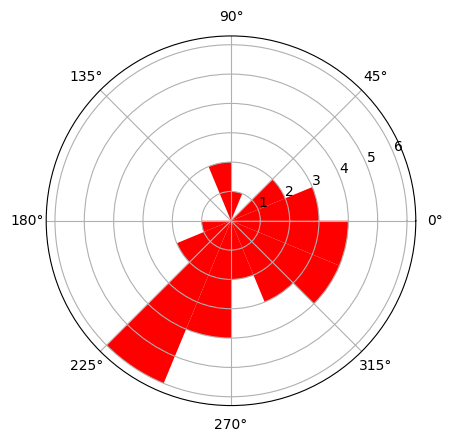

TypeError: can only concatenate str (not "int") to str

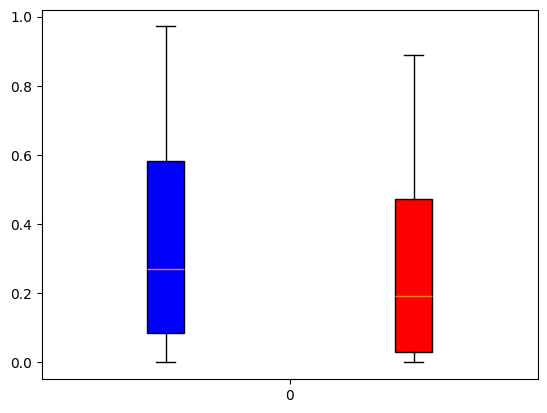

In [48]:
P_THRESH = 0.2

# make empty result dictionary
all_spk_angles = {}

# for each superburst
for i, sb in enumerate(SB_TIMES):
    print(sb)

    # load LFP data
    with open("/workspaces/human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
        data_raw = pickle.load(filename)

    # filter LFP data into individual frequency bands
    data = get_brain_waves(data_raw["data"], data_raw["frame_rate"]) #[wave_type]  # get common brain waves

    # get theta filtered data
    theta_filt = data["theta"]

    # if this is the first iteration of the loop
    if i == 0:

        # obtain electrode coordinates
        elec_xy = data_raw["xy"].copy()
        elec_xy[:,1] = data_raw["xy"][:,0]/12.5
        elec_xy[:,0] = data_raw["xy"][:,1]

        # obtain unit locations
        unit_xy = []
        for unit in sd.neuron_data[0].values():
            unit_xy.append([unit['position'][0], unit['position'][1]] )
        unit_xy = np.array(unit_xy)

        # find NUM_CLOSEST closest electrodes to each unit
        closest_elecs = find_k_closest_rows(unit_xy, elec_xy, NUM_CLOSEST)


    # for each unit
    for unit in range(len(sd.train)):

        # average the theta LFP over the closest electrodes
        av_nearby_theta = np.mean(theta_filt[closest_elecs[unit,:], :], axis=0)

        # compute the phase angles of the averaged theta
        nearby_angles = np.angle(hilbert(av_nearby_theta))

        # get spike times from sd
        spk_times= np.unique( np.round(sd.train[unit]).astype(int) )

        # filter for spike times in superburst only
        sb_spk_times = spk_times[(spk_times > sb[0]*1000) & (spk_times < sb[1]*1000)]

        # obtain all spike time angles
        spk_angles = nearby_angles[sb_spk_times-sb[0]*1000]

        if i == 0:
            all_spk_angles[unit] = spk_angles
        else:
            all_spk_angles[unit] = np.append(all_spk_angles[unit], spk_angles)

mean_angle = np.zeros((len(sd.train),))
rayleigh_p = np.zeros((len(sd.train),))

# for each unit
for unit in range(len(sd.train)):

    # compute rayleigh test per unit
    rayleigh_p[unit] = rayleightest(all_spk_angles[unit])

    if rayleigh_p[unit] <= P_THRESH:

        # compute average spike angle and store
        mean_angle[unit] = circmean(all_spk_angles[unit])

    else:

        # set mean angle to NaN
        mean_angle[unit] = np.nan


clus0_angles = [mean_angle[unit] for unit in clus0_units if not np.isnan(mean_angle[unit])]
clus1_angles = [mean_angle[unit] for unit in clus1_units if not np.isnan(mean_angle[unit])]
clus0_p = [rayleigh_p[unit] for unit in clus0_units if not np.isnan(rayleigh_p[unit])]
clus1_p = [rayleigh_p[unit] for unit in clus1_units if not np.isnan(rayleigh_p[unit])]

plot_polar_hist(clus0_angles, nbins=16, bar_color="b")
plot_polar_hist(clus1_angles, nbins=16, bar_color="r")


create_boxplot({"0": [clus0_p, clus1_p]}, "Rayleigh P")

[9, 28]
loading saved results
[38, 52]
loading saved results
[69, 83]
loading saved results
[138, 151]
loading saved results
[176, 187]
loading saved results
[211, 220]
loading saved results
[246, 254]
loading saved results


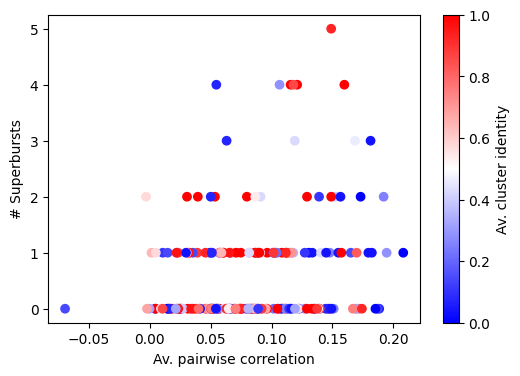

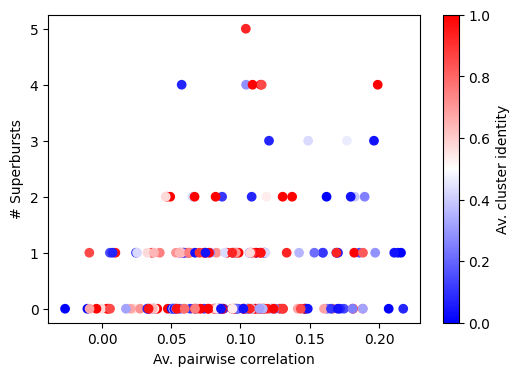

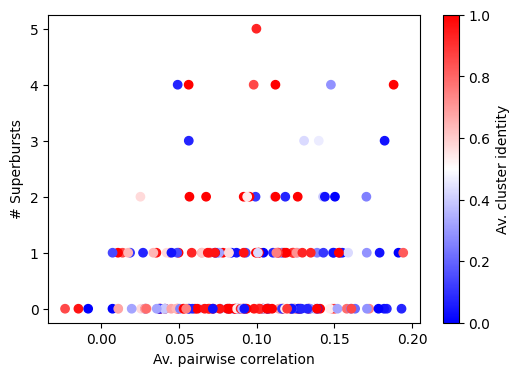

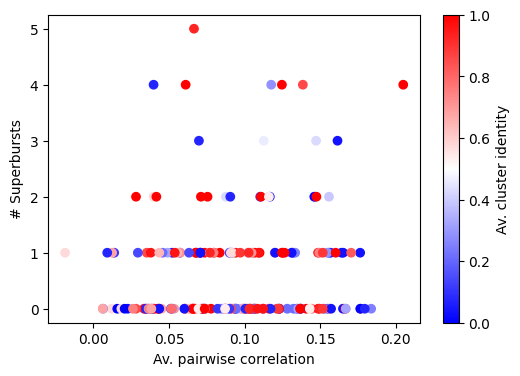

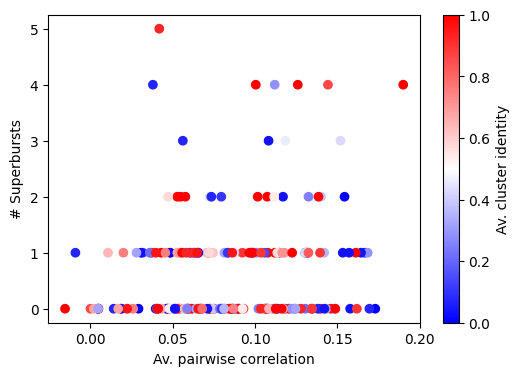

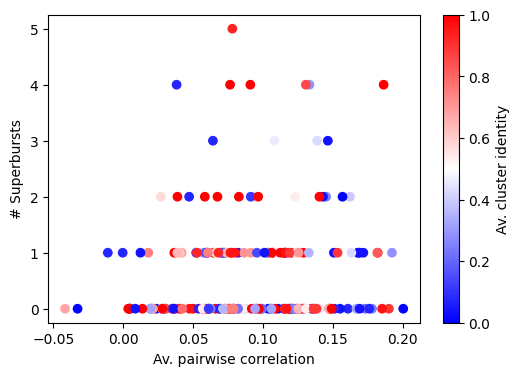

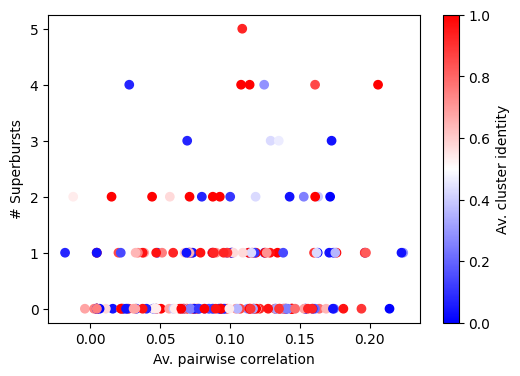

In [36]:
# Set the maximum lag time in ms 
MAX_LAG = 50


# for each superburst
for sb in SB_TIMES:
    print(sb)

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_spike_rate_data_recomp_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # if results already exist
    if os.path.exists(data_save_path):
        
        print("loading saved results")

        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            max_corr = data['max_corr']
            lag_times = data['lag_times']
            isi_rate = data['isi_rate']

    else:
        
        print("computing correlations")

        # compute firing rate for superburst
        isi_rate = compute_rate_isi(sd, TIME_RANGE=sb)

        max_corr, lag_times = compute_cross_corr_lag_range(isi_rate, MAX_LAG)

        # Save the data to a file
        with open(data_save_path, 'wb') as f:
            pickle.dump({'isi_rate': isi_rate, 'max_corr': max_corr, 'lag_times': lag_times}, f)

        print("results saved")

    # replace nan with 0
    max_corr = np.nan_to_num(max_corr)
    av_corr = np.mean(max_corr, axis=0)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Plot a scatterplot in the second subplot
    scatter = ax.scatter(av_corr, locked_sb, c=unit_av_clus_id, cmap="bwr")#, s=1./(std_phase**2))
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label('Av. cluster identity')
    ax.set_xlabel('Av. pairwise correlation')
    ax.set_ylabel('# Superbursts')


    

[9, 28]
loading saved results
[38, 52]
loading saved results
[69, 83]
loading saved results
[138, 151]
loading saved results
[176, 187]
loading saved results
[211, 220]
loading saved results
[246, 254]
loading saved results


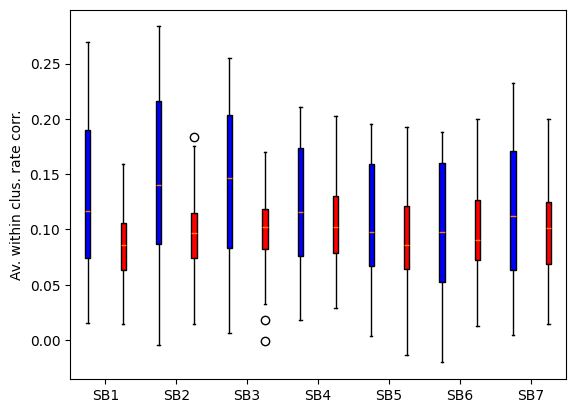

                 sum_sq     df          F        PR(>F)
C(CLUS)        0.136118    1.0  53.259504  7.532214e-13
C(SB)          0.038555    6.0   2.514264  2.045653e-02
C(CLUS):C(SB)  0.054057    6.0   3.525189  1.903149e-03
Residual       1.896373  742.0        NaN           NaN


In [37]:
# initiate empty result dictionary
av_clus_corr = {}

# for each superburst
for i, sb in enumerate(SB_TIMES):
    print(sb)

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_spike_rate_data_recomp_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # if results already exist
    if os.path.exists(data_save_path):
        
        print("loading saved results")

        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            max_corr = data['max_corr']
            lag_times = data['lag_times']
            isi_rate = data['isi_rate']

    else:
        
        print("computing correlations")

        # compute firing rate for superburst
        isi_rate = compute_rate_isi(sd, TIME_RANGE=sb)

        max_corr, lag_times = compute_cross_corr_lag_range(isi_rate, MAX_LAG)

        # Save the data to a file
        with open(data_save_path, 'wb') as f:
            pickle.dump({'isi_rate': isi_rate, 'max_corr': max_corr, 'lag_times': lag_times}, f)

        print("results saved")

    # replace nan with 0
    max_corr = np.nan_to_num(max_corr)

    clus0_units_list = list(clus0_units)
    clus0_units_list.sort()
    clus0_units_array = np.array(clus0_units_list)

    clus1_units_list = list(clus1_units)
    clus1_units_list.sort()
    clus1_units_array = np.array(clus1_units_list)

    av_clus_corr[i] = [np.mean(max_corr[clus0_units_array, :][:, clus0_units_array], axis=0), np.mean(max_corr[clus1_units_array, :][:, clus1_units_array], axis=0)]
    



# plot average correlation results
create_boxplot(av_clus_corr, "Av. within clus. rate corr.")


Unsuccesful attempts below

[9, 28]
loading saved results


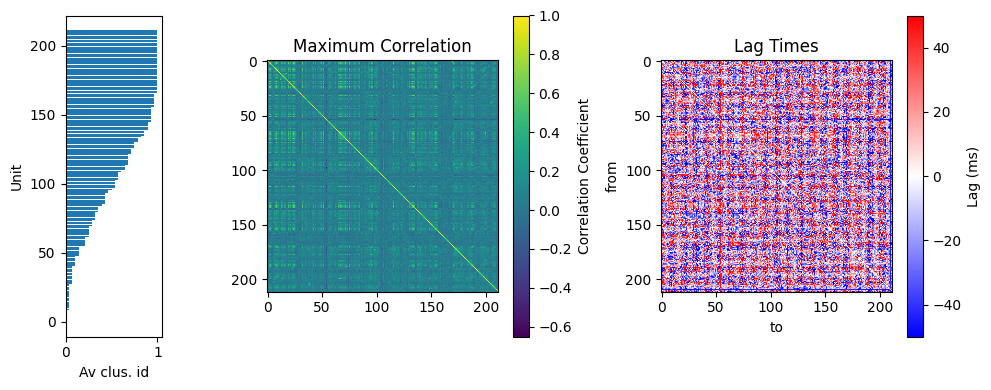

[38, 52]
computing correlations
0


/tmp/ipykernel_1834/609716287.py:63: RuntimeWarning: invalid value encountered in divide
  signal2_scaled = signal2_scaled / np.linalg.norm(signal2_scaled)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


/tmp/ipykernel_1834/609716287.py:57: RuntimeWarning: invalid value encountered in divide
  signal1_scaled = signal1_scaled / np.linalg.norm(signal1_scaled)


66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


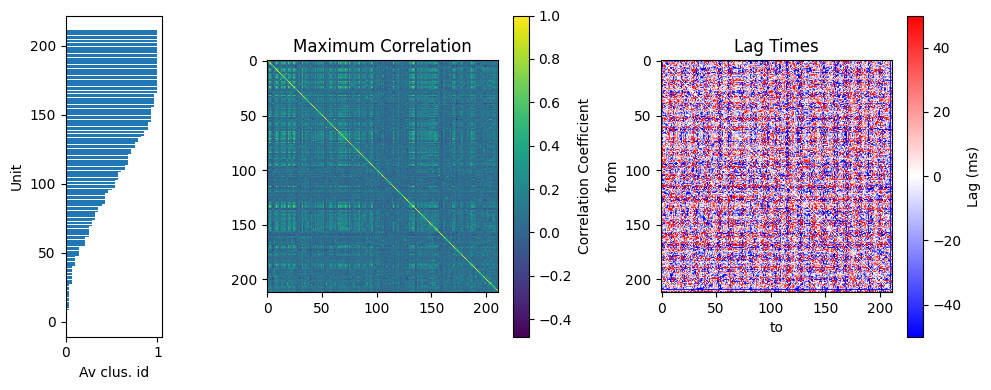

[69, 83]
computing correlations
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


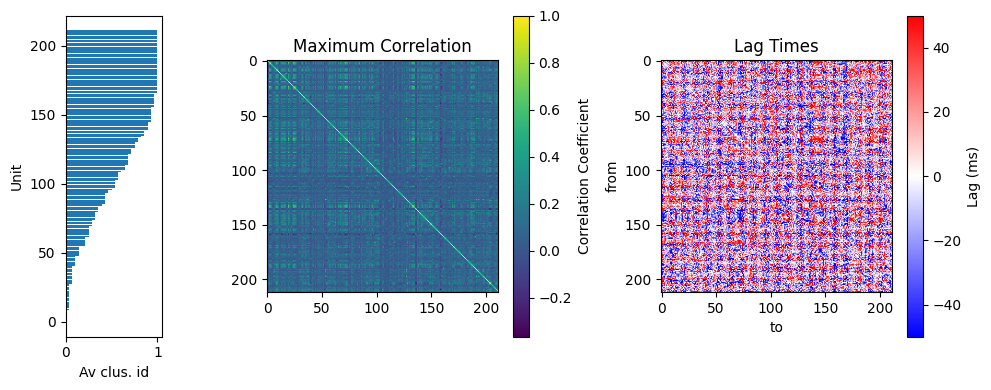

[138, 151]
computing correlations
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


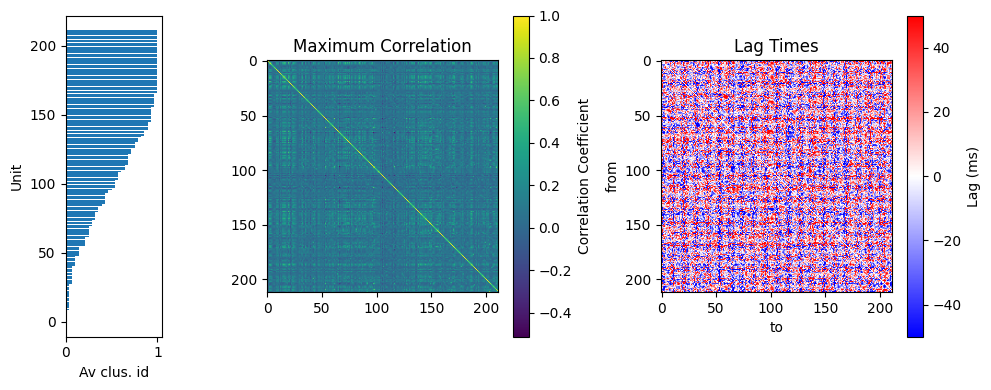

[176, 187]
computing correlations
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


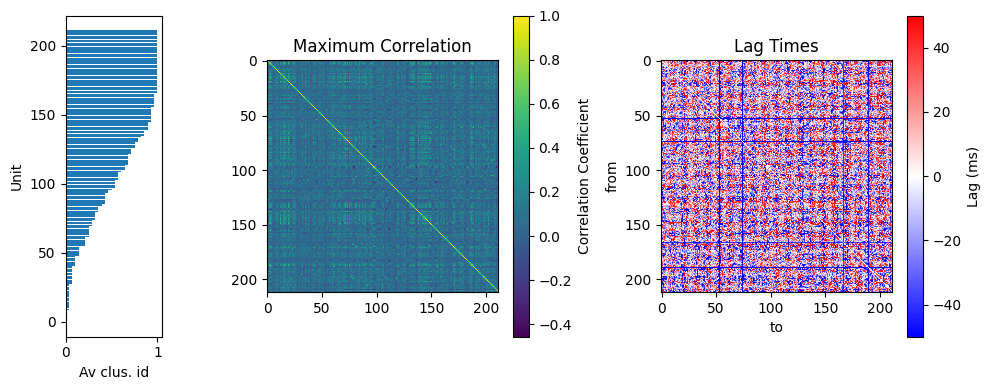

[211, 220]
computing correlations
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


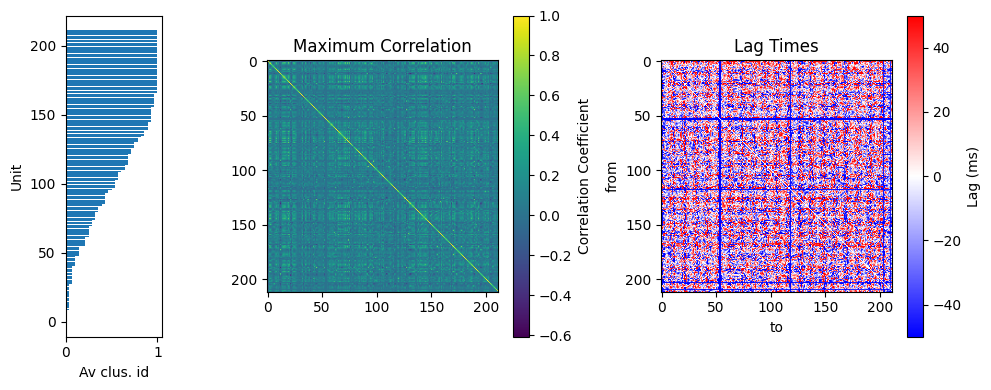

[246, 254]
computing correlations
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
results saved


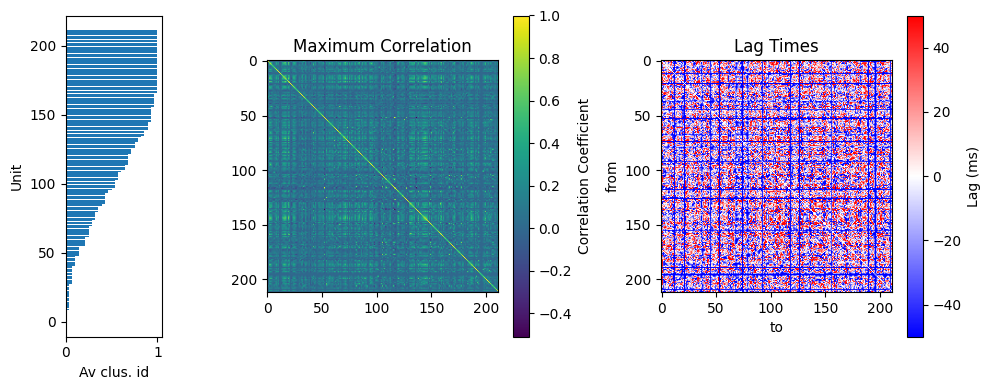

In [26]:
# Set the maximum lag time in ms 
MAX_LAG = 50


# for each superburst
for sb in SB_TIMES:
    print(sb)

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_spike_rate_data_recomp_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # if results already exist
    if os.path.exists(data_save_path):
        
        print("loading saved results")

        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            max_corr = data['max_corr']
            lag_times = data['lag_times']
            isi_rate = data['isi_rate']

    else:
        
        print("computing correlations")

        # compute firing rate for superburst
        isi_rate = compute_rate_isi(sd, TIME_RANGE=sb)

        max_corr, lag_times = compute_cross_corr_lag_range(isi_rate, MAX_LAG)

        # Save the data to a file
        with open(data_save_path, 'wb') as f:
            pickle.dump({'isi_rate': isi_rate, 'max_corr': max_corr, 'lag_times': lag_times}, f)

        print("results saved")

    # replace nan with 0
    max_corr = np.nan_to_num(max_corr)

    # # # Perform k-means clustering on the max_corr matrix and create ordering array based on results
    # kmeans = KMeans(n_clusters=NCLUS, random_state=SEED).fit(max_corr)
    # labels = kmeans.labels_
    # unit_order = np.argsort(labels)

    # # order units based on based on unit_av_clus_id 
    unit_order = np.argsort(unit_av_clus_id)
    
    # reorder max_corr and lag_times based on unit_order
    reordered_max_corr = max_corr[:, unit_order][unit_order, :]
    reordered_lag_times = lag_times[:, unit_order][unit_order, :]


    # Create a figure with a 2x2 subplot layout
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 3, 3]})

    # Plot a horizontal barplot of the reordered array on the third subplot
    ax1.barh(range(len(unit_av_clus_id)), unit_av_clus_id[unit_order])
    ax1.set_xlabel('Av clus. id')
    ax1.set_ylabel('Unit')

    # Plot the original max_corr heatmap
    im2 = ax2.imshow(reordered_max_corr, cmap='viridis')
    ax2.set_title('Maximum Correlation')

    # Plot the original lag_times heatmap with the bwr colormap
    im3 = ax3.imshow(reordered_lag_times, cmap='bwr')
    ax3.set_title('Lag Times')
    ax3.set_xlabel('to')
    ax3.set_ylabel('from')

    # Show the colorbars
    fig.colorbar(im2, ax=ax2, label='Correlation Coefficient')
    fig.colorbar(im3, ax=ax3, label='Lag (ms)')

    plt.tight_layout()
    plt.show()
    # plt.savefig(fig_save_path + "2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.png".format(sb[0], sb[1], MAX_LAG))
    # print("correlation matrix figure saved")



    # # select highest correlated cluster only
    # count_0 = np.count_nonzero(labels == 0)
    # count_1 = np.count_nonzero(labels == 1)

    # if count_0 > count_1:
    #     clus_oi = 1
    # elif count_0 < count_1:
    #     clus_oi = 0
    # else:
    #     clus_oi = 0

    # sub_max_corr = max_corr[:, labels==clus_oi][labels==clus_oi, :]
    # sub_lag_times = lag_times[:, labels==clus_oi][labels==clus_oi, :]
    # sub_unit_av_clus_id = unit_av_clus_id[labels==clus_oi]

    # # # Perform k-means clustering on the lag_times matrix
    # kmeans = KMeans(n_clusters=NCLUS, random_state=SEED).fit(sub_lag_times)
    # labels = kmeans.labels_
    # sub_unit_order = np.argsort(labels)

    # # # order units based on based on unit_av_clus_id 
    # sub_unit_order = np.argsort(sub_unit_av_clus_id)

    # # reorder max_corr and lag_times based on unit_order
    # reordered_sub_max_corr = sub_max_corr[:, sub_unit_order][sub_unit_order, :]
    # reordered_sub_lag_times = sub_lag_times[:, sub_unit_order][sub_unit_order, :]

    # # Create a figure with a 2x2 subplot layout
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 3, 3]})

    # # Plot a horizontal barplot of the reordered array on the third subplot
    # ax1.barh(range(len(sub_unit_av_clus_id)), sub_unit_av_clus_id[sub_unit_order])
    # ax1.set_xlabel('Av clus. id')
    # ax1.set_ylabel('Unit')

    # # Plot the original max_corr heatmap
    # im2 = ax2.imshow(reordered_sub_max_corr, cmap='viridis')
    # ax2.set_title('Maximum Correlation')

    # # Plot the original lag_times heatmap with the bwr colormap
    # im3 = ax3.imshow(reordered_sub_lag_times, cmap='bwr')
    # ax3.set_title('Lag Times')
    # ax3.set_xlabel('to')
    # ax3.set_ylabel('from')

    # # Show the colorbars
    # fig.colorbar(im2, ax=ax2, label='Correlation Coefficient')
    # fig.colorbar(im3, ax=ax3, label='Lag (ms)')

    # plt.tight_layout()
    # plt.show()
    # # plt.savefig(fig_save_path + "2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.png".format(sb[0], sb[1], MAX_LAG))
    # # print("correlation matrix figure saved")


In [19]:
print(max_corr.shape)

(212, 212)


0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


/tmp/ipykernel_1834/609716287.py:63: RuntimeWarning: invalid value encountered in divide
  signal2_scaled = signal2_scaled / np.linalg.norm(signal2_scaled)
/srv/conda/envs/notebook/lib/python3.10/site-packages/scipy/signal/_signaltools.py:243: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)
/tmp/ipykernel_1834/609716287.py:57: RuntimeWarning: invalid value encountered in divide
  signal1_scaled = signal1_scaled / np.linalg.norm(signal1_scaled)


1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


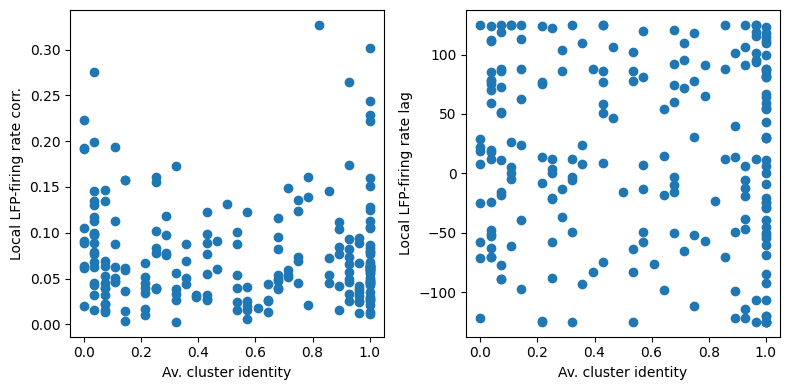

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


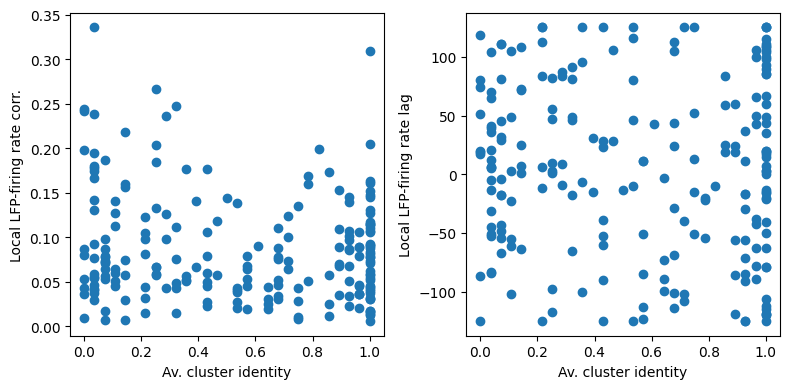

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


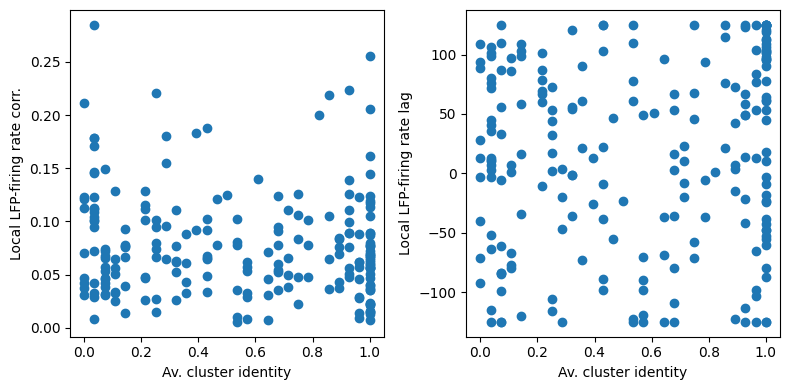

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


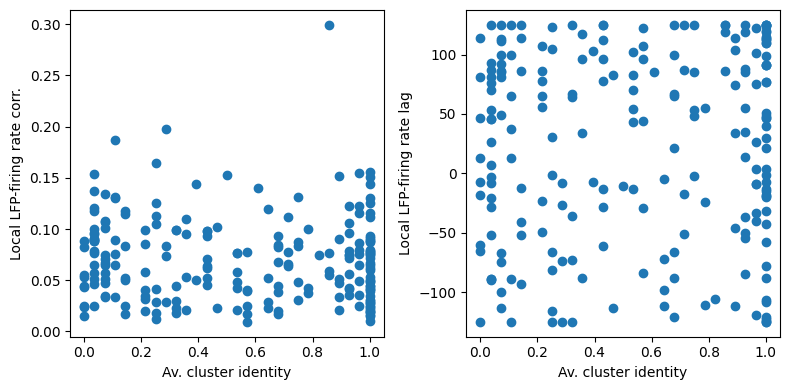

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


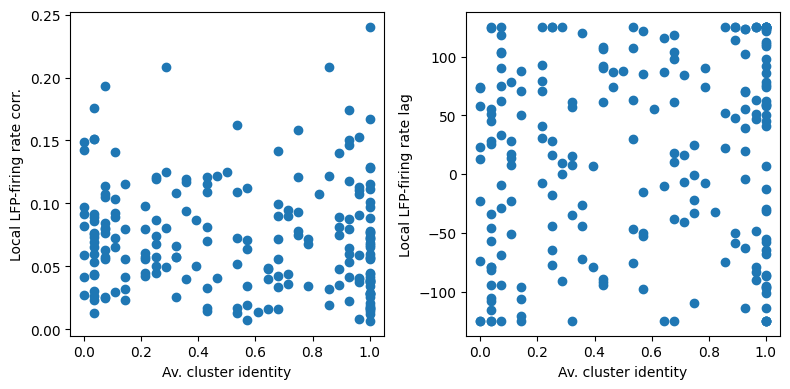

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


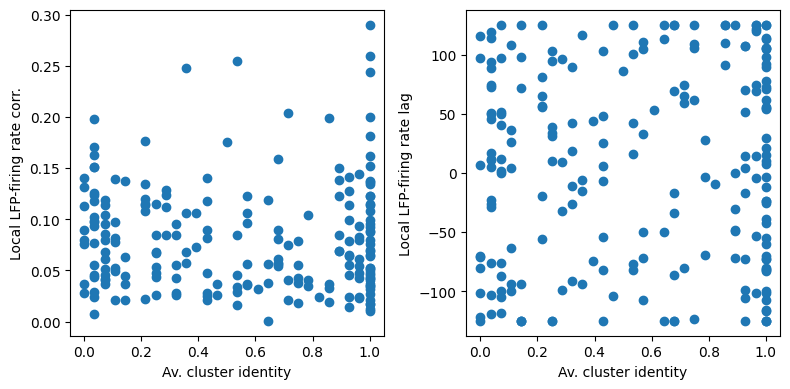

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


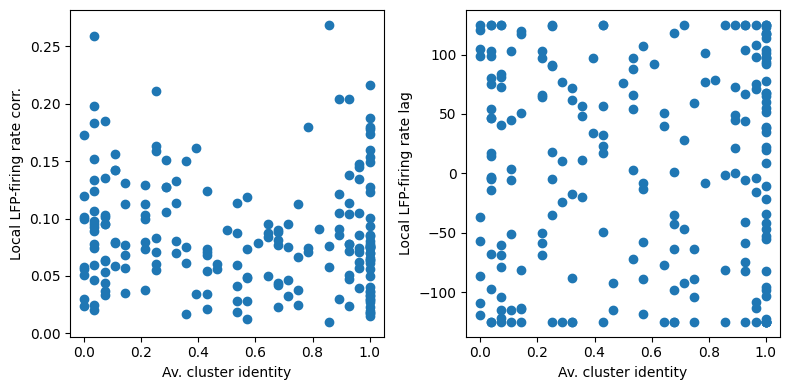

In [38]:
# compute firing rate over time per unit (ISI method)

# for every superburst
for sb in SB_TIMES:

    # define data save path given parameters
    data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_corr_data_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], MAX_LAG)

    # if results already exist
    if os.path.exists(data_save_path):
        
        # load data
        with open(data_save_path, 'rb') as f:
            data = pickle.load(f)

            theta_filt = data['theta_filt']

    else:

        print("WARNING: no saved data for superburst: {}s to {}s".format(sb[0], sb[1]))

    # compute firing rate for superburst
    isi_rate = compute_rate_isi(sd, TIME_RANGE=sb)

    # initiate empty result array
    data_per_unit = np.zeros((isi_rate.shape[0], 3))

    # for every unit
    for unit in range(isi_rate.shape[0]):

        # get theta signal from nearby electrodes
        av_theta_nearby = np.mean(theta_filt[closest_elecs[unit,:]], axis=0)

        # compute average cluster score
        av_clus_score = np.mean([av_clus_vals[i] for i in closest_elecs[unit,:]])

        # compute cross correlation and lag
        cross_cor, max_lag = compute_cross_corr_lag_range(np.vstack((av_theta_nearby, isi_rate[unit,:])), 125)

        # store results
        data_per_unit[unit,:] = [av_clus_score, cross_cor[0,1], max_lag[0,1]]


    # Create the figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Create the first scatter plot
    ax1.scatter(data_per_unit[:, 0], data_per_unit[:, 1])
    ax1.set_xlabel('Av. cluster identity')
    ax1.set_ylabel('Local LFP-firing rate corr.')

    # Create the second scatter plot
    ax2.scatter(data_per_unit[:, 0], data_per_unit[:, 2])
    ax2.set_xlabel('Av. cluster identity')
    ax2.set_ylabel('Local LFP-firing rate lag')

    # Show the plot
    plt.tight_layout()
    plt.show()